In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2
from PIL import Image, ImageEnhance, ImageOps

# Preparing Dataset

In [2]:
# takes a PIL image, enhances its contrast, converts it to grayscale, and applies a binary threshold.
def enhance_contrast_and_threshold(img, threshold=128):
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(img)
    enhanced_img = enhancer.enhance(3.0)  # Adjust the factor as needed

    # Convert to grayscale and apply binary threshold
    bw = ImageOps.grayscale(enhanced_img)
    bw = bw.point(lambda p: p > threshold and 255)

    return bw

In [3]:
# change the root directory to yours
root_path = r"C:\Users\ezgi\Desktop\'23-'24 fall\deep learning\term project\data"  # the root directory where the images are stored

images = []  # list to store the preprocessed images
labels = []  # list to store the corresponding labels

valid_extensions = {".jpg", ".jpeg", ".png"}

for cam_folder in os.listdir(root_path):
    cam_folder_path= os.path.join(root_path, cam_folder)
    for folder_name in os.listdir(cam_folder_path):
        folder_path = os.path.join(cam_folder_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if any(file_name.lower().endswith(ext) for ext in valid_extensions):
                    image_path = os.path.join(folder_path, file_name)
                    # Extract label from the file name (the label is the second part split by underscores)
                    label = file_name.split('_')[1]
                    
                    # Load the image using PIL
                    pil_image = Image.open(image_path)

                    # Enhance contrast and apply threshold
                    enhanced_image = enhance_contrast_and_threshold(pil_image)  # CONTRAST

                    # Convert PIL image to NumPy array
                    img = np.array(enhanced_image)

                    if img is None:
                        print(f"Failed to load image: {image_path}")
                    else:
                        img = cv2.resize(img, (64, 64))  # resize the image to 64x64 pixels
                        images.append(img)  # image added to the 'images' list
                        labels.append(label)  # label added to the 'labels' list


In [12]:
# convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# array is modified to include a single channel for compatibility with Conv2D layer
images = images.reshape(images.shape + (1,))  

# print the information about the number of images and labels
print("Number of images:", len(images))  
print("Number of labels:", len(labels))  

# encode labels into numerical format, they were letters
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# normalize pixel values to be between 0 and 1
images = images / 255.0

Number of images: 21042
Number of labels: 21042


In [18]:
images.shape

(21042, 64, 64, 1)

In [19]:
labels_encoded.shape

(21042,)

The final result is a set of preprocessed images (images) and their corresponding numerical labels (labels_encoded).

# Exploratory Data Analysis (EDA) 

### Visualization of Images

Displaying random images using a grayscale color map

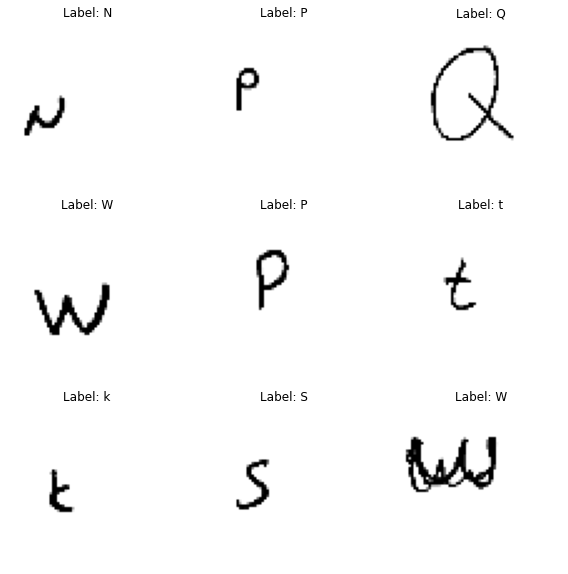

In [26]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 10))
random_indices = random.sample(range(len(images)), 9)  # get random indices from the dataset

for i, idx in enumerate(random_indices):  # display 9 randomly selected images in a 3x3 grid
    plt.subplot(3, 3, i+1) 
    plt.imshow(images[idx].reshape(64, 64), cmap='gray')  # display the image at the random index, reshaped to 64x64, using a grayscale color map
    plt.title(f"Label: {labels[idx]}")  # set the title of the subplot with the corresponding label
    plt.axis('off')  # turn off axis labels and ticks

plt.show() 


Displaying a few random sample images without using grayscale map. We will train our models using these images:

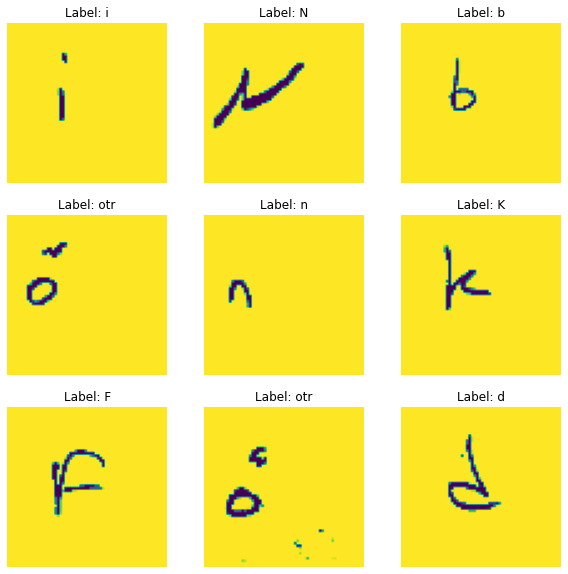

In [21]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 10))
random_indices = random.sample(range(len(images)), 9)  # get random indices from the dataset

for i, idx in enumerate(random_indices):  # display 9 randomly selected images in a 3x3 grid
    plt.subplot(3, 3, i+1) 
    plt.imshow(images[idx])  # display the image at the random index
    plt.title(f"Label: {labels[idx]}")  # set the title of the subplot with the corresponding label
    plt.axis('off')  # turn off axis labels and ticks

plt.show() 


### Class Distribution

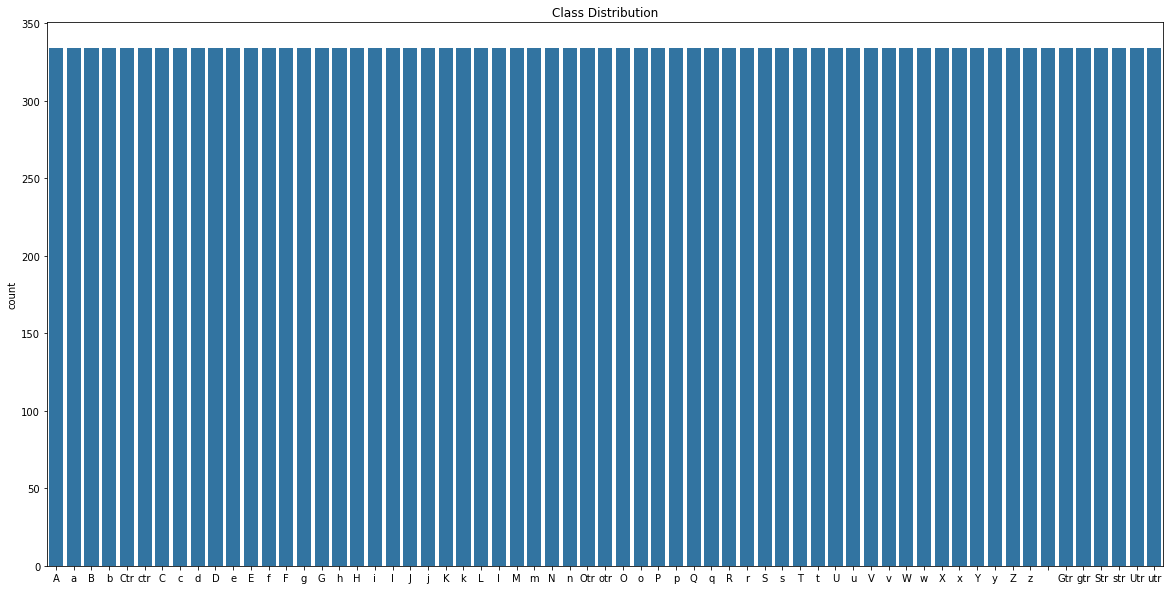

In [29]:
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(20, 10))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.show()

In [32]:
# Display class counts
class_counts = {label: labels.tolist().count(label) for label in set(labels)}
print("Class Counts:", class_counts)

Class Counts: {'O': 334, 'A': 334, 't': 334, 'Y': 334, 'I': 334, 'C': 334, 'S': 334, 's': 334, 'v': 334, 'h': 334, 'G': 334, 'o': 334, 'i': 334, 'Z': 334, ' ': 334, 'R': 334, 'a': 334, 'P': 334, 'V': 334, 'p': 334, 'e': 334, 'l': 334, 'N': 334, 'J': 334, 'gtr': 334, 'Utr': 334, 'y': 334, 'K': 334, 'u': 334, 'Otr': 334, 'X': 334, 'utr': 334, 'str': 334, 'b': 334, 'c': 334, 'z': 334, 'f': 334, 'H': 334, 'Ctr': 334, 'w': 334, 'g': 334, 'F': 334, 'n': 334, 'Gtr': 334, 'otr': 334, 'D': 334, 'q': 334, 'U': 334, 'r': 334, 'x': 334, 'B': 334, 'j': 334, 'ctr': 334, 'M': 334, 'T': 334, 'Str': 334, 'L': 334, 'W': 334, 'm': 334, 'k': 334, 'E': 334, 'd': 334, 'Q': 334}


* There are 334 samples from each class, indicating a balanced distribution of samples across classes. It helps to prevent the model from being biased towards one particular class.

### Image Statistics

In [34]:
mean_pixel_value = np.mean(images)
print(f"Mean Pixel Value: {mean_pixel_value}")

Mean Pixel Value: 0.9744084904147858


* The mean pixel value is an indicator of the average brightness of the images in the dataset.
* A mean pixel value of approximately 0.9744 suggests that, on average, the pixel values are close to 1.0. Since we normalized the pixel values to be between 0 and 1, this is expected. <br>

In [35]:
std_pixel_value = np.std(images)
print(f"Standard Deviation of Pixel Value: {std_pixel_value}")

Standard Deviation of Pixel Value: 0.15329414349018125


* The standard deviation measures the amount of variation or dispersion. In the context of image pixel values:
    - A low standard deviation (close to 0) indicates that most pixel values are close to the mean, suggesting less variability in brightness.
    - A high standard deviation indicates more variability in pixel values.
* In our dataset, a standard deviation of approximately 0.1533 indicates that the pixel values have moderate variability around the mean.

### Image Histograms

Plotting histograms of pixel intensities to understand the distribution of pixel values of the images

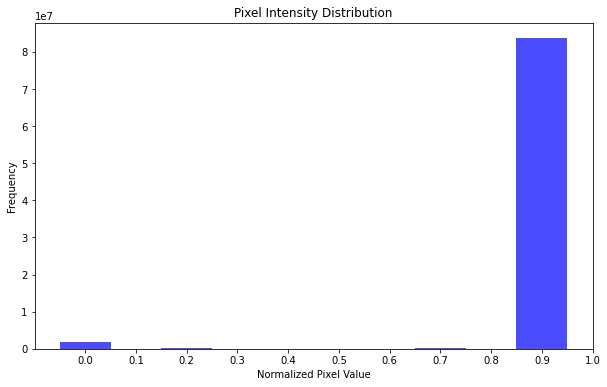

In [45]:
plt.figure(figsize=(10,6))
bins = np.arange(0, 1.01, 0.1)
plt.bar(bins[:-1], np.histogram(images.flatten(), bins=bins)[0], width=0.1, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Normalized Pixel Value')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.show()

In [46]:
# Calculate histogram
hist, bins = np.histogram(images.flatten(), bins=np.arange(0, 1.01, 0.1))

# Create a dictionary to store frequencies
frequency_dict = {f'{bins[i]:.2f}-{bins[i+1]:.2f}': hist[i] for i in range(len(hist))}

# Print frequencies in descending order
sorted_frequencies = sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True)
for bin_range, frequency in sorted_frequencies:
    print(f"Range: {bin_range}, Frequency: {frequency}")


Range: 0.90-1.00, Frequency: 83683308
Range: 0.00-0.10, Frequency: 1908486
Range: 0.70-0.80, Frequency: 85298
Range: 0.20-0.30, Frequency: 84711
Range: 0.80-0.90, Frequency: 80018
Range: 0.10-0.20, Frequency: 76536
Range: 0.50-0.60, Frequency: 69046
Range: 0.40-0.50, Frequency: 68333
Range: 0.30-0.40, Frequency: 66571
Range: 0.60-0.70, Frequency: 65725


* Images with pixel values close to 0 might have darker areas.
* The high frequency in the 0.90-1.00 range suggests that a substantial portion of the images has bright pixel values, while other ranges represent variations in brightness.